# Approximating electromagnetic shielding using deep learning

Here we are digging the deep learning part of the automated learning. We wish to see by ourselves to which extends this is appliable to our case and if it gives better results than standard machine learning.

When designing algorithms, we always have to wonder what are the requirements in terms of time / performance trade-off. In our case, the performance is the most important. Computation time should of course stay reasonable but considering the time taken to construct the matrix on which we train, as long as our algorithms don't take several minutes to run they will not take the major part of the overall time.

Note that deep-learning algorithms rely a lot on data. The more you have, the better your predictions will be. Hence we highly recommand that whenever more data are available to rerun the algorithms.

In [23]:
# Clean up the memory
%reset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload
%autoreload 2

import gc

import src.crowd as crowd
import src.experts as experts
import src.supercrowd as sc
import src.collaborative_crowd as cc

import numpy as np
import math
from PIL import Image
import timeit

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.constraints import MaxNorm

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.75

In [3]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))
    
    
def basic_error(pred, real):
    '''
    Compute basic error. Used to notify bias.
    :param : float[]
    :param : float[]
    :return : float
    '''
    err = 0
    for i in range(len(pred)):
        err += (pred[i][0][0] - real[i])
    return err


def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [4]:
def plot_history(history):
    '''
    Plots the history of the training error
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])
    
    
def plot_crowd_dist_4(crowd, s1, s2, s3, s4):
    nb_bins = 8
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.subplot(221)
    crowd.plot_error_dist_on_sample(s1[0], s1[1], basic_error, show = False, bins = nb_bins)
    plt.subplot(222)
    crowd.plot_error_dist_on_sample(s2[0], s2[1], basic_error, show = False, bins = nb_bins)
    plt.subplot(223)
    crowd.plot_error_dist_on_sample(s3[0], s3[1], basic_error, show = False, bins = nb_bins)
    plt.subplot(224)
    crowd.plot_error_dist_on_sample(s4[0], s4[1], basic_error, show = False, bins = nb_bins)
    plt.show()

## Preparing the data

First, we need to prepare the data in a train / test split. The test part is required to have good approximation of the error on unseen data. The lab asked for a $75$ / $25$ train / test split, we select the samples at random to avoid training only on a subset of the data (note that this is overkill since the lab revealed us that the samples were already randomized).

And the last, but not the least, detail : we add a random seed in our random selection to ensure reproducibility.

In [5]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

train_set_size = int(len(X_red) * TRAIN_SET_PERC)
# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


# Single neural network model approach 

First, we want to see how well a single neural network can perform on the data we have at our disposal. Highly influenced by tensorflow's tutorials and Standford University CS231n Convolutional Neural Networks for Visual Recognition lecture (http://cs231n.github.io/), we build our first neural network.

We also execute cross-validations on the relevant parameters to get the best RMSE out of the network.

In [19]:
def train_and_pred(nb_layers, nb_neurons, regularizer_fac, optimizer_fac):
    # Prepare model 
    model = tf.keras.Sequential()
    for i in range(nb_layers):
        model.add(layers.Dense(nb_neurons, activation='relu', \
                               kernel_regularizer=tf.keras.regularizers.l2(regularizer_fac)))
    # Last layer represent the electromagnetic shielding, our prediction
    model.add(layers.Dense(1, activation='relu'))

    model.compile(optimizer=tf.train.AdamOptimizer(optimizer_fac),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
    EPOCHS = 200
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.1
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
              callbacks=[early_stop])
    plot_history(history)
    
    result = model.predict(X_test_red, batch_size=32)
    error = rmse(result, y_test)
    print("Error : {}".format(error))
    return error

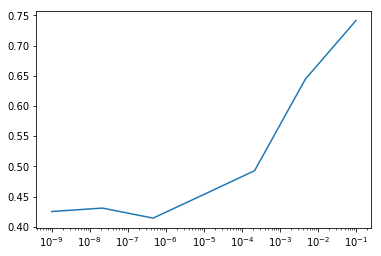

In [22]:
errors = [0.7416394267991249, 0.6443409956831526, 0.4930030937745785, \
         0.453638706377575, 0.41453323956187177, 0.4311010863788413, 0.4254569121978898]

x = np.logspace(-1, -9, 7)

plt.semilogx(x, errors)

In [ ]:
# This will train the neural network and print its error on the test set.
# Since tensorflow is very talkative when training a network, we remove the output for the comfort of the reader.
error = train_and_pred(8, 156, 1e-6, 0.001)

## Results of cross validation over regularization factor

For the sake of sanity, we only display the results we obtained to avoid recomputing them. The previous graph shows evolution of the RMSE for a single neural network versus the L2 regularization factor.

The number of layers and neurons by layers was chosen such that the model is powerful enough to capture most of the complexity of the model, overfitting being taken care with the L2-regularization. 

As for the optimizer factor, it will not influence the accuracy of our predictions but rather the convergence times. Hence we chose a factor that allowed us to converge while keeping a decent amount of epochs.

## Final optimized structure :

- Train / test split : $75$ / $25$.
- Number of hidden layers : $8$.
- Number of neuron / layers : $156$.
- Activations : Rectified Linear Unit (relu).
- Regularizer : L2 regularizer with factor $10^{-6}$.
- Optimizer : Adam Optimizer with factor $10^{-3}$.
- Single network error : 0.43.

# Crowd of Neural Networks Approach

Now we try a new approach based on the *Wisdom Of Crowds* principle which states that the average of the predictions of a crowd is almost always better than the prediction of a single expert.

Hence we will create a Crowd composed of a multitude of networks, train them all on the same training set and then ask them all to predict the test data. We will then average their predictions to give the final answer of the crowd, counting on the randomness of the neural network algorithm to give different answers for each individual, needed assumption for the principle to hold.

Note that most of the code for this part is located in the Crowd class, itself defined in the file crowd.py.

The structure of each networks we use is the optimized one we found in the previous part. Note also that the crowds are pretty long to train, to have good approximations, the more networks they have, the better. However this training should be done only once and each network is saved in the directory of its crowd in the folder '/session'.

In [13]:
crowd_opt2 = crowd.Crowd(X_train_red, y_train, "Crowd_opt_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
# Recover the crowd from file.
# The file should be located in the 'session' folder
crowd_opt2.restore()

Recovered 16 entities from session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/16


In [6]:
# This will add new networks to the crowd. Note that this is a long operation (up to 2 hours for 8 entities).
crowd_opt2.train_new_entities(8)

In [25]:
# Predict on the test set and compute RMSE
start = timeit.default_timer()
pred = crowd_opt2.predict(X_test_red)
stop = timeit.default_timer()
error_rmse = rmse(pred, y_test)
print('Prediction time for {} samples : {} seconds\nRMSE : {} '.format(len(X_test_red), stop - start, error_rmse))

Prediction time for 7513 samples : 185.83958538400475 seconds
RMSE : 0.35298389679256353 


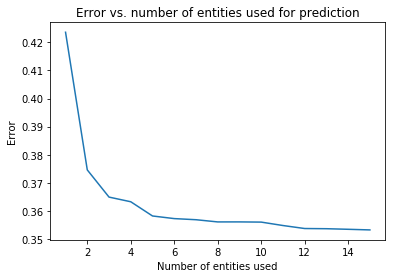

In [26]:
# Plot the crowd error vs the number of networks used for prediction
crowd_opt2.plot_crowd_error(X_test_red, y_test, rmse)

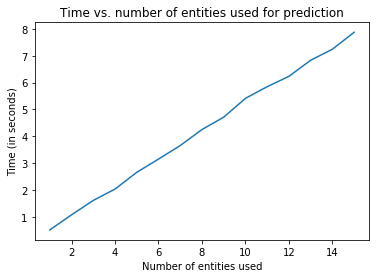

In [27]:
# Plot the prediction time vs the number of networks used
crowd_opt2.plot_crowd_pred_time(X_test_red)

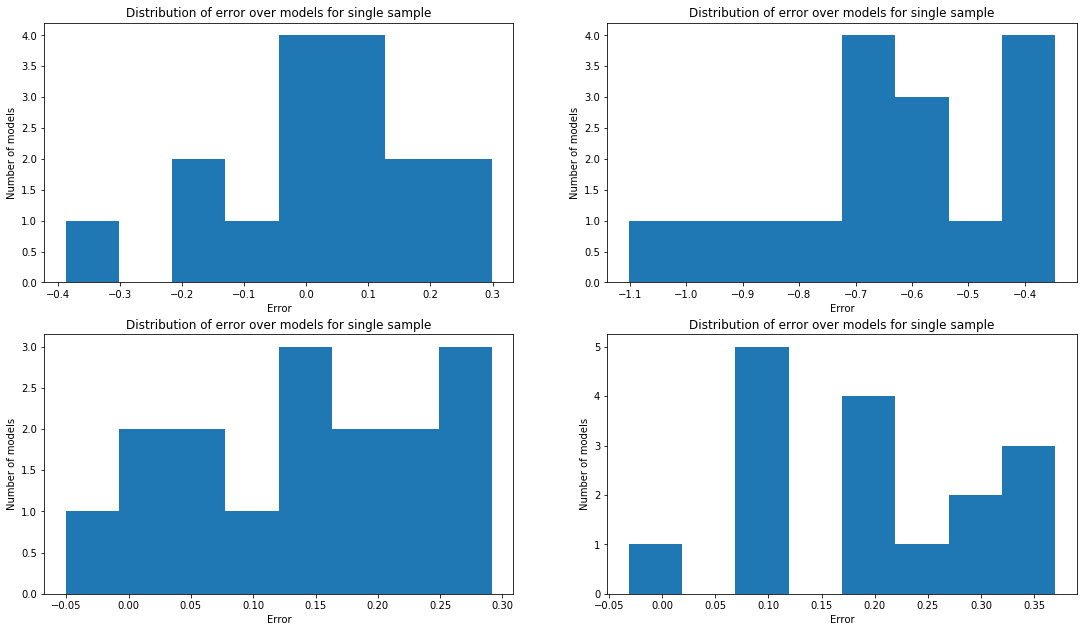

In [15]:
# Plot the distribution of the error of the different networks over a single sample
plot_crowd_dist_4(crowd_opt2, (X_test_red[0], y_test[0]), (X_test_red[1], y_test[1]), \
                  (X_test_red[2], y_test[2]), (X_test_red[3], y_test[3]))

### A wild idea : use a neural network stacked above the crowd for the prediction

This idea is not detailed in the report because it doesn't bring better results than the ones we already have. And because we are limited to 4 pages for the report we had to make choices.

This type of predictions adds a neural network on top of the crowd to make the prediction. This network will train on the whole training matrix but also on all the predictions of the other networks of the crowd. Doing so should learn him how the other networks did and it may ameliorate its predictions with this knowledge.

In [ ]:
# Make a prediction using a stacker at the end of the crowd
# Again output is removed because of tensorflow verbosity.
print("RMSE using stacker : {}".format(rmse(crowd_opt2.predict_stacked(X_test_red), y_test)))

## Conclusion

Looking at the error versus the number of networks used for prediction, the results is undeniable : the crowd definetely reduce our error in an impressive way.

We can clearly see that the error follows an exponential decay when compared to the number of networks used for a linear increase of the computation time. From the plot of the distribution of the error over a single sample, we can see that it is more or less gaussianly distributed. However we observe that this gaussian distribution is not centered around 0 which means that adding more and more networks will not necessarly brought us to a RMSE of $0$. 

Consequently, we have to find better ways of ameliorate the error.

As a side note, please consider the error obtained with the stacked_prediction. Although it is not as good as the average of the predictions of the crowd (around $0.35$) it is better than the single network error (around $0.43$). Keep this in mind since it will be the starting point of our collaborative crowds.

## Final structure :

- Each network composing the crowd is an instance of the optimized version found in the first part.
- 16 entities (more will bring better results but also increase the prediction time).
- Crowd error : $0.353$.

# Mixture of experts

Finally we want to test a last method : instead of assigning the same weight to the prediction of each individual of the Crowd, we will try to assign different weights based on ressemblance between the sample to predict and the samples on which the individual performed best. 

If the data is categorizable, this method may give very good results. The core code is located in the file experts.py.

In [6]:
experts01 = experts.Experts(X_train_red, y_train, "Experts_opt1", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
experts01.restore()

Recovered 8 entities from session/Experts_opt1_8_156_relu_1e-06_0.001_mse/8


In [ ]:
experts01.train_new_entities(8)

## Prediction using gating network

Here we want to train a gating network on a matrix $[S, b]$ where $S$ is the training samples and $b$ is the neural network that performed best on that sample. Then at prediction time, we ask to this gating network to assign to each neural network composing the crowd a probability that it should be selected. We then compute our final prediction :
$$\hat{y} = \sum_{i=1}^k p_i \hat{y}_i$$
Where $\hat{y}$ is the final prediction, $\hat{y}_i$ is the prediction of network $i$ and $p_i$ is the probability that network $i$ should be selected to make the prediction according to the gating network.

In [ ]:
# Triggers the construction of the gating network (actual predictions will be computed in next cell for clarity)
# Again output is removed because of the verbose of sklearn
experts01.predict(X_test_red)

In [9]:
rmse(experts01.predict(X_test_red), y_test), \
rmse(experts01.predict(X_train_red), y_train)

(0.374657711965834, 0.039667213888995106)

## Prediction using k-means clustering

The previous predictions being unsuccessful, we try another approach. We will cluster the data thanks to a k-mean algorithm (from the library sklearn) and then assign to each cluster the networks that have the smallest average RMSE over the cluster. At prediction time we assign the new sample to the closest cluster and use the related networks for prediction. This may work if data belonging to a given cluster are equally well predicted by a given set of networks.

In [ ]:
experts01.predict_kmeans(X_test_red, rmse, 8)

In [11]:
rmse(experts01.predict_kmeans(X_test_red, rmse, 8), y_test), \
rmse(experts01.predict_kmeans(X_train_red, rmse, 8), y_train)

(0.3765282421913312, 0.07056080187493417)

## Conclusion on mixture of experts

None of the two algorithms described above were successful. We got good results, but nothing better than the prediction of the crowd. Hence we didn't push this idea any further. Moreover, this system is assumed to work well when the data can be categorized in subsets where some networks may perform better than others. It is not the case here.

### Best results :
- Using deep learning categorizer : $0.375$
- Using clustering : $0.377$

# Collaborative crowd

Let's recall the wild idea we had when using the crowd of neural networks. The idea was to stack a neural network on top of the crowd and train it on the training data where we appended the predictions of the other networks of the crowd.

We push this idea further and allow each network of the crowd to access the predictions of the other networks previously added. This will allow the newcomer to known what the others predicted, how wrong they were and to adjust its predictions based on this knownledge.

The core code for this part is located in collaborative_crowd.py.

In [6]:
cc1 = cc.CollaborativeCrowd(X_train_red, y_train, "CollabCrowd_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
cc1.restore()

Recovered 16 entities from session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16


In [ ]:
cc1.train_new_entities(8)

In [7]:
last, avg, last5 = cc1.predict(X_test_red, True)
print("Last entity RMSE : {}".format(rmse(last, y_test)))
print("Last 5 entities RMSE : {}".format(rmse(last5, y_test)))
print("Average RMSE : {}".format(rmse(avg, y_test)))

Last entity RMSE : 0.3812139181354184
Last 5 entities RMSE : 0.3586411031403149
Average RMSE : 0.3489545411525422


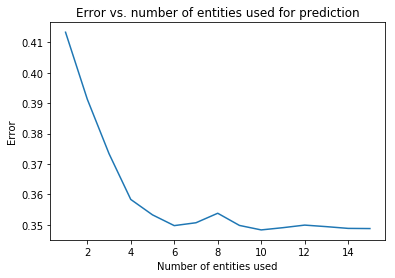

In [9]:
cc1.plot_crowd_error(X_test_red, y_test, rmse)

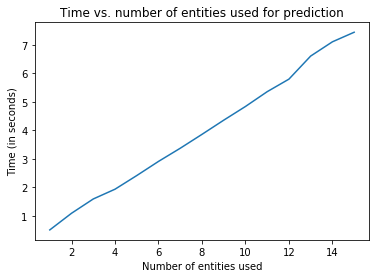

In [11]:
cc1.plot_crowd_pred_time(X_test_red)

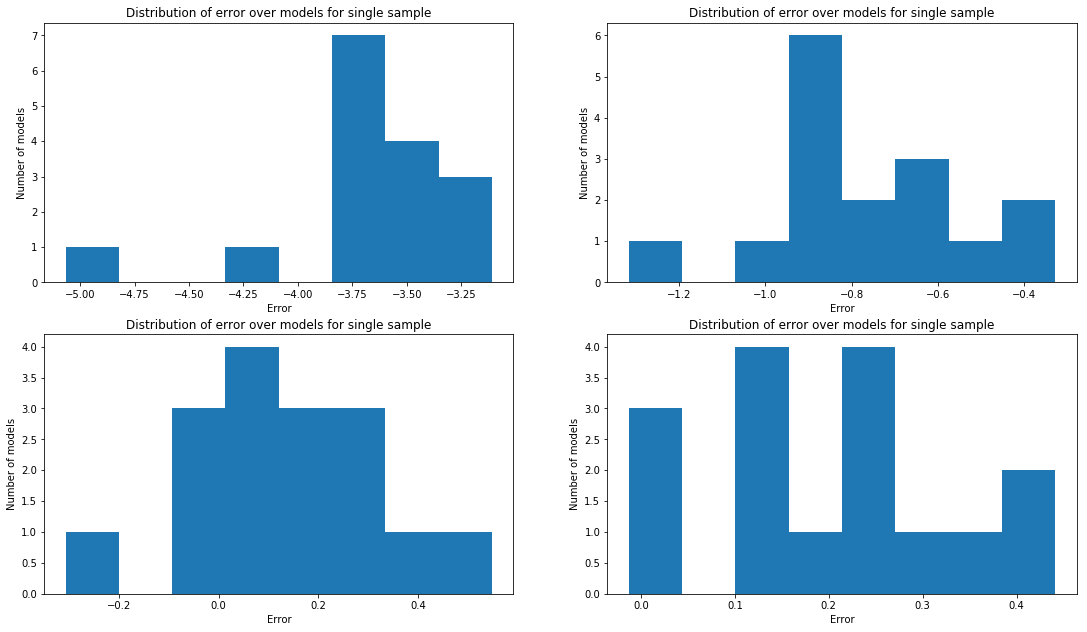

In [27]:
plot_crowd_dist_4(cc1, (X_test_red[0], y_test[0]), (X_test_red[1], y_test[1]), \
                  (X_test_red[2], y_test[2]), (X_test_red[3], y_test[3]))

## Results of collaborative crowd

The collaborative crowd brought better results, we can observe that the newcomers indeed have an error way smaller than the first networks appended to the crowd.

Above you can see that the last network performed with a RMSE of $0.38$ over the test set. The new average error has dropped by around $0.004$ compared to the standard crowd which represents $1\%$ of the error, which is a quite tiny improvement.

We also remark that the distribution of the predictions for one samples has changed. Some samples are very well predicted (average close to 1) while some others are very far from the truth. Further investigation on this phenomena could be conducted, however considering the time given for this project we will not be able to do them.

## Final structure :

- Each network composing the crowd is an instance of the optimized version found in the first part and has been trained on both the training data and the predictions of the other networks composing the crowd.
- 16 entities (more will bring better results but also increase the prediction time).
- Collaborative crowd error : $0.349$.

# SuperCrowd

The super crowd has been made with the idea that different estimators may be combined to offer even better estimations. The idea behind this is to vary the sources of biases. Two systems may have the same bias, however it will not be distributed the same way on all the samples. Consequently some biases may balance each others on some samples and reduce the error.

If we combine two models with similar RMSE, the output of the supercrowd prediction will perform at least as well as them and there's high chances that it performs better.

The class is following the Composite design pattern. Each element composing the SuperCrowd should have a predict(matix) method in order for the algorithm to work.

The core code of this class is located in supercrowd.py.

In [8]:
supercrowd = sc.SuperCrowd()

cc1 = cc.CollaborativeCrowd(X_train_red, y_train, "CollabCrowd_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
cc1.restore()

crowd_opt2 = crowd.Crowd(X_train_red, y_train, "Crowd_opt_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
crowd_opt2.restore()

supercrowd.append_crowd(cc1)
supercrowd.append_crowd(crowd_opt2)

Recovered 16 entities from session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
Recovered 16 entities from session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/16


In [11]:
rmse(supercrowd.predict(X_test_red), y_test)

0.3419144346517784

## Results
The accuracy of the prediction has been increased. However, note that the computation time is now the sum of all the computation times of all the crowds composing the supercrowd. However we remark that we reduced our RMSE of $0.008$ which is still a good amelioration.

### Best result
- Combinaison of the optimal crowd and the collaborative crowd described above.
- Super Crowd error : $0.342$.

# Dropout & max-norm constraint

Dropout layers combined with max-norm constraints are referenced in the litterature as a good way to avoid overfitting (N. Srebro and A. Shraibman _Rank, trace-norm and max-norm_). Since we remarked some overfit during the training of our neural network (a training error less that $0.1$ while the test error is around $0.4$ ) we wanted to see if those techniques were worth bringing in the equation. 

We hence execute a bunch of cross-validations on the input dropout percentage, the inter-layer dropout percentage and the max-norm value to see if we can have better results using them.

In [15]:
def cv_dropout_maxnorm(df_in, df_hidden, max_norm):
    model = tf.keras.Sequential()
    model.add(layers.Dropout(df_in))
    for i in range(8):
        model.add(layers.Dense(156, activation='relu', \
                               kernel_regularizer=tf.keras.regularizers.l2(1e-6), \
                               kernel_constraint=MaxNorm(max_norm)))
        model.add(layers.Dropout(df_hidden))
    # Last layer represent the electromagnetic shielding, our prediction
    model.add(layers.Dense(1, activation='relu'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
    EPOCHS = 200
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.1
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
              callbacks=[early_stop])
    plot_history(history)

    result = model.predict(X_test_red, batch_size=32)
    error = rmse(result, y_test)
    print("Error : {}".format(error))
    return error

In [ ]:
# Cross validation on the dropout percentage on the input, the one between the layers and the max-norm.
# Again we don't display the run for clarity purposes
errors = []
for df_in in [0.2, 0.3]:
    print("df_in = " + str(df_in))
    for df_hidden in [0.4, 0.5]:
        print("    df_hidden = " + str(df_hidden))
        for max_norm in [3, 4]:
            print("        max_norm = " + str(max_norm))
            errors.append(cv_dropout_maxnorm(df_in, df_hidden, max_norm))

### Conclusion on dropout & max-norm

Those techniques don't bring better results than what we already have. Even after trying with several different combinaisons, we couldn't do better than $0.45$ for a single network RMSE. 

# Collaborative Crowd on jittered matrix

Another good way to increase performances of a neural network is to artificially add samples to the matrix we already have.

In [5]:
X_train_red = np.load(DATA_FOLDER + "x_pca_train.npy")
y_train = np.load(DATA_FOLDER + "y_pca_train.npy")
X_test_red = np.load(DATA_FOLDER + "x_pca_test.npy")
y_test = np.load(DATA_FOLDER + "y_pca_test.npy")
X_train_red.shape, y_train.shape, X_test_red.shape, y_test.shape

((22761, 3004), (22761,), (7513, 3004), (7513,))

In [6]:
cc_jitt = cc.CollaborativeCrowd(X_train_red, y_train, "CollabCrowd_jitter", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
cc_jitt.restore()

No directory with name session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse


In [ ]:
cc_jitt.train_new_entities(1)

In [9]:
last, avg, last5 = cc_jitt.predict(X_test_red)
rmse(avg, y_test)

3.117733862088689